In [ ]:
import os
os.mkdir('./pubyc_renderer_parallel')

In [ ]:
%%file ./pubyc_renderer_parallel/abstand.pxd
cdef void Abstand (double [:, :], double[:, :], int, int, int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/abstand.pyx
cimport cython
#Abstands Funktion
#Abstand_Sonne = position[1] - position[0]

@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Abstand (double [:, :] position_view , double[:, :] result ,int head, int tail, int id) nogil: 
    result[id][0] = position_view[head][0] - position_view[tail][0]
    result[id][1] = position_view[head][1] - position_view[tail][1]
    result[id][2] = position_view[head][2] - position_view[tail][2]

In [ ]:
%%file ./pubyc_renderer_parallel/betrag.pxd
cdef void Betrag (double [:, :], double[:], int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/betrag.pyx
from libc.math cimport sqrt
cimport cython

#Betrags Funktion
#Betrag_Erde  = sqrt( Abstand_Erde**2 + Abstand_Erde**2 + Abstand_Erde**2)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Betrag (double [:, :] abstand_view , double[:] result, int id) nogil:
    result[id] = sqrt(abstand_view[id][0]**2 + abstand_view[id][1]**2 + abstand_view[id][2]**2)

In [ ]:
%%file ./pubyc_renderer_parallel/kraft.pxd
cdef void Kraft (double [:], double [:, :],  double [:], int, int, double[:, :], int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/kraft.pyx
cimport cython

#Kraft Funktion
#Kraft_Erde = G * (masse_erde * masse_sonne / (Betrag_Erde  ** 3)) * Abstand_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Kraft (double [:] masse_view, double [:, :] abstand_view,  double [:] Betrag, \
                  int head, int tail, double[:, :] result, int id) nogil:
    
    cdef double g1 = 6.672
    cdef double g2 = 10
    cdef double g3 = -11
    
    cdef double G = g1 * g2 ** g3
    cdef double betrag = Betrag[id] ** 3

    cdef double masse_multyply = masse_view[head] * masse_view[tail]
    
    result[id][0] = G * (masse_multyply / betrag) * abstand_view[id][0]
    result[id][1] = G * (masse_multyply / betrag) * abstand_view[id][1]
    result[id][2] = G * (masse_multyply / betrag) * abstand_view[id][2]

In [ ]:
%%file ./pubyc_renderer_parallel/beschleunigung.pxd
cdef void Beschleunigung (double [:, :], double [:], int, double[:, :], int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/beschleunigung.pyx
cimport cython

#Beschleunigungs Funktion
#Beschleunigung_Erde  = Kraft_Erde  / masse
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Beschleunigung (double [:, :] kraft_view , double [:] masse_view, \
                          int massen_index, double[:, :] result, int id) nogil:
    cdef float G = 6.672 * 10 ** -11
    result[id][0] = kraft_view[id][0]  / masse_view[massen_index]
    result[id][1] = kraft_view[id][1]  / masse_view[massen_index]
    result[id][2] = kraft_view[id][2]  / masse_view[massen_index]

In [ ]:
%%file ./pubyc_renderer_parallel/update_position.pxd
cdef void update_position (double [:, :], double [:, :], double [:, :],double [:, :], double, int, int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/update_position.pyx
cimport cython

#Positions Aktualliersierung
#position = position + dt * geschwindigkeit  + ((dt ** 2) / 2) * Beschleunigung_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_position (double [:, :] position_view , double [:, :] new_postion_view, \
                   double [:, :] speed_view, double [:, :] beschleunigung_view, \
                        double dt, int planet_index, int id) nogil:
    
    new_postion_view[planet_index][0] = position_view[planet_index][0]  + dt * speed_view[planet_index][0] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[id][0]
        
    new_postion_view[planet_index][1] = position_view[planet_index][1]  + dt * speed_view[planet_index][1] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[id][1]
        
    new_postion_view[planet_index][2] = position_view[planet_index][2]  + dt * speed_view[planet_index][2] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[id][2]

In [ ]:
%%file ./pubyc_renderer_parallel/update_speed.pxd
cdef void update_speed (double [:, :], double [:, :], double [:, :], double, int, int) nogil

In [ ]:
%%file ./pubyc_renderer_parallel/update_speed.pyx
cimport cython

#Geschwindigkeits Aktuallisierung
#geschwindigkeit[0][0]  += dt * Beschleunigung_Erde[0]
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_speed (double [:, :] speed_view, double [:, :] new_speed_view, \
                        double [:, :] beschleunigung_view, double dt ,int planet_index, int id) nogil:
    new_speed_view[planet_index][0] = speed_view[planet_index][0] + dt * beschleunigung_view[id][0]
    new_speed_view[planet_index][1] = speed_view[planet_index][1] + dt * beschleunigung_view[id][1]
    new_speed_view[planet_index][2] = speed_view[planet_index][2] + dt * beschleunigung_view[id][2]

In [ ]:
%%file ./pubyc_renderer_parallel/loop.pyx
from cython.parallel import prange , threadid
from multiprocessing import cpu_count

from abstand cimport Abstand
from betrag cimport Betrag
from kraft cimport Kraft
from beschleunigung cimport Beschleunigung
from update_position cimport update_position
from update_speed cimport update_speed
import numpy as np
cimport cython

@cython.boundscheck(False)
cpdef Loop (_args_dt, position, speed, masse):
    
    #Umwandlung in MemoryView
    cdef double [:, :] position_view = position
    cdef double [:, :] speed_view = speed
    cdef double [:, :] new_position_view = position
    cdef double [:, :] new_speed_view = speed 
    cdef double [:] masse_view = masse

    #Statische Variable
    cdef int dt = _args_dt
    cdef int number_planets = len(position)
    cdef int i, current_planet, planet
    
    #Temporaere MemoryView zum ZwischenSpeichern
    cdef int id
    cdef thread_num = cpu_count()  
    
    cdef double [:, :] distance = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:] magnitude = np.zeros(thread_num,  dtype=np.float64)
    cdef double [:, :] single_force = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:, :] all_force = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:, :] acceleration = np.zeros((thread_num, 3),  dtype=np.float64)
    
    for current_planet in prange (number_planets, nogil=True):
        id = threadid()
        all_force[id][0] = 0
        all_force[id][1] = 0
        all_force[id][2] = 0

        for planet in range(number_planets):  
            
            if (planet != current_planet):
                Abstand(position_view, distance, planet, current_planet, id)
                Betrag(distance, magnitude, id)
                Kraft(masse_view, distance, magnitude, planet, current_planet, single_force, id)
                all_force[id][0] += single_force[id][0]
                all_force[id][1] += single_force[id][1]
                all_force[id][2] += single_force[id][2]

        Beschleunigung(all_force, masse_view, current_planet, acceleration, id)
        update_position(position_view, new_position_view, speed_view, acceleration, dt, current_planet, id) 
        update_speed(speed_view , new_speed_view, acceleration, dt, current_planet, id)          

    position_view = new_position_view
    speed_view = new_speed_view
    
    position = np.asarray(position_view)
    speed = np.asarray(speed_view)


In [ ]:
%%file ./pubyc_renderer_parallel/setup.py


# Aufruf: python3 setup.py build_ext --inplace
# Windows: zusaetzliche Option --compiler=mingw32
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy


ext_modules=[ Extension("abstand", ["abstand.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("betrag", ["betrag.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
              Extension("kraft", ["kraft.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("beschleunigung", ["beschleunigung.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("update_position", ["update_position.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("update_speed", ["update_speed.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("loop", ["loop.pyx"],
        extra_compile_args=['-O3', '-fopenmp'], libraries=['m'],
        extra_link_args=['-fopenmp'],)
        
        #Maybe needed
        #extra_compile_args=['-O3'], libraries=['m'],
        #include_dirs=[numpy.get_include()]),
]
             
setup( name = 'cython demo',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules,
     include_dirs=[numpy.get_include()])



## Compile Cython

In [ ]:
%%bash
cd ./pubyc_renderer_parallel
#Compilen
python3 setup.py build_ext --inplace

## Start in Juypter

In [1]:
%load_ext Cython
%load_ext autoreload

In [2]:
#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_speed = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

In [3]:
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./pubyc_renderer_parallel")

from loop import Loop
import matplotlib.pyplot as plt
import numpy as np

plot_list = []
dt = 60 * 60 * 24 
year = 60 * 60 * 24 * 365 * 165
iteration = (int)(year / dt)

position = np.array(python_position, dtype=np.float64)
speed = np.array(python_speed,dtype=np.float64)
masse = np.array(python_masse,dtype=np.float64)

for i in range(iteration):
    Loop(dt, position, speed, masse)
    pos_list_entry = []
    for list_index in range(len(python_position)):
        pos_list_entry.append(np.array((position[list_index][0], position[list_index][1],\
        position[list_index][2]), np.float64))
        
    plot_list.append(np.array(pos_list_entry, np.float64))

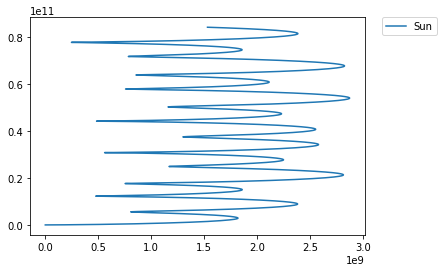

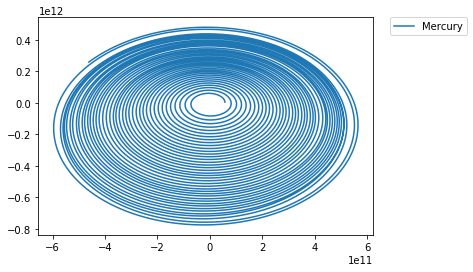

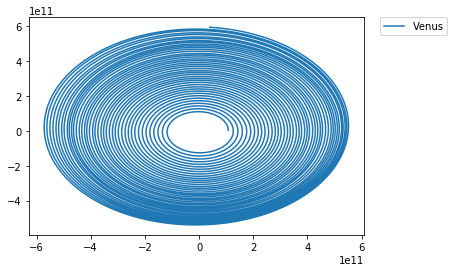

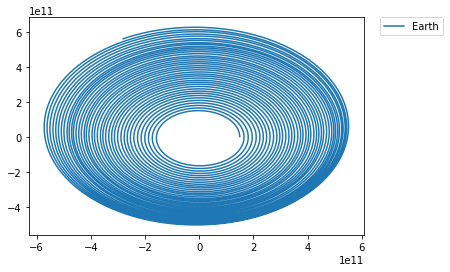

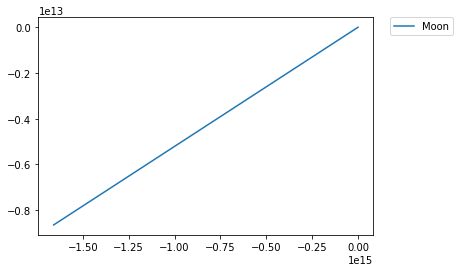

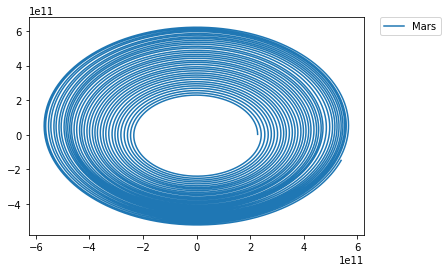

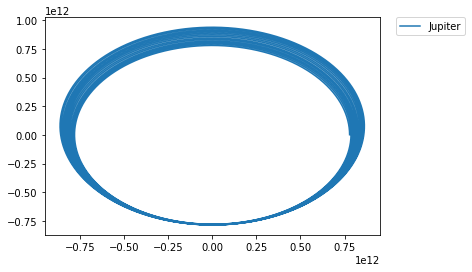

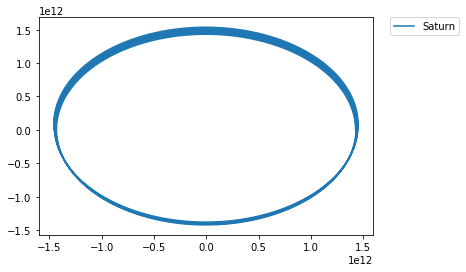

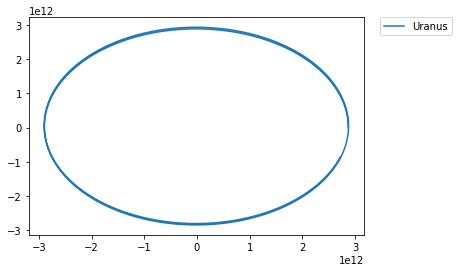

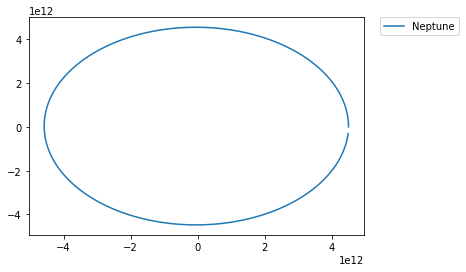

plot_list_length 60225
[[  1.05220562e+03   2.10090312e-03   0.00000000e+00]
 [  5.77614796e+10   4.13614081e+09   0.00000000e+00]
 [  1.08166632e+11   3.02581446e+09   0.00000000e+00]
 [  1.49575759e+11   2.57363423e+09   0.00000000e+00]
 [  1.49487455e+11   3.84653394e+08   0.00000000e+00]
 [  2.27927108e+11   2.08491841e+09   0.00000000e+00]
 [  7.78411203e+11   1.12916160e+09   0.00000000e+00]
 [  1.42672516e+12   8.35660802e+08   0.00000000e+00]
 [  2.87097214e+12   5.90544000e+08   0.00000000e+00]
 [  4.49825288e+12   4.73212800e+08   0.00000000e+00]]
[[  4.20870957e+03   7.00006432e+00   0.00000000e+00]
 [  5.73187718e+10   8.26173251e+09   0.00000000e+00]
 [  1.08039755e+11   6.05044620e+09   0.00000000e+00]
 [  1.49509369e+11   5.14700775e+09   0.00000000e+00]
 [  1.49332723e+11   3.85168773e+08   0.00000000e+00]
 [  2.27898513e+11   4.16974965e+09   0.00000000e+00]
 [  7.78408752e+11   2.25832201e+09   0.00000000e+00]
 [  1.42672442e+12   1.67132147e+09   0.00000000e+00]
 [  

In [4]:
plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (20):
    print(plot_list[_])

## TimeIt

In [ ]:
%timeit Loop(dt, position, speed, masse)

#313 µs ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#356 µs ± 132 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#370 µs ± 157 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#276 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

## Galaxy Renderer

In [ ]:
%%file ./pubyc_renderer_parallel/galaxy_renderer.py
"""
OpenGL output for gravity simulation
"""
#
# Copyright (C) 2017  "Peter Roesch" <Peter.Roesch@fh-augsburg.de>
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 3
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program; if not, write to the Free Software
# Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA  02111-1307, USA.
# or open http://www.fsf.org/licensing/licenses/gpl.html
#
import sys
import time

try:
    from OpenGL import GLUT
    from OpenGL import GL
    from OpenGL import GLU
except ImportError:
    print(' Error: Software not installed properly !!')
    sys.exit()

from mouse_interactor import MouseInteractor
from simulation_constants import END_MESSAGE

# initial window parameters
_WINDOW_SIZE = (512, 512)
_WINDOW_POSITION = (100, 100)
_LIGHT_POSITION = (2, 2, 3)
_CAMERA_POSITION = (0, 0, 22)


class GalaxyRenderer:
    """
        Class containing OpenGL code
    """

    def __init__(self, render_pipe, fps):
        self.render_pipe = render_pipe
        self.fps = fps
        self.bodies = None
        self.do_exit = False
        self.sphere = None
        self.init_glut()
        self.init_gl()
        self.mouse_interactor = MouseInteractor(0.01, 1)
        self.mouse_interactor.register_callbacks()

    def init_glut(self):
        """
            Set up window and main callback functions
        """
        GLUT.glutInit(['Galaxy Renderer'])
        GLUT.glutInitDisplayMode(GLUT.GLUT_DOUBLE | GLUT.GLUT_RGB)
        GLUT.glutInitWindowSize(_WINDOW_SIZE[0], _WINDOW_SIZE[1])
        GLUT.glutInitWindowPosition(_WINDOW_POSITION[0], _WINDOW_POSITION[1])
        GLUT.glutCreateWindow(str.encode("Galaxy Renderer"))
        GLUT.glutDisplayFunc(self.render)
        GLUT.glutIdleFunc(self.update_positions)

    def init_gl(self):
        """
            Initialise OpenGL settings
        """
        self.sphere = GL.glGenLists(1)
        GL.glNewList(self.sphere, GL.GL_COMPILE)
        quad_obj = GLU.gluNewQuadric()
        GLU.gluQuadricDrawStyle(quad_obj, GLU.GLU_FILL)
        GLU.gluQuadricNormals(quad_obj, GLU.GLU_SMOOTH)
        GLU.gluSphere(quad_obj, 1, 32, 32)
        GL.glEndList()
        GL.glShadeModel(GL.GL_SMOOTH)
        GL.glEnable(GL.GL_DEPTH_TEST)
        GL.glEnable(GL.GL_CULL_FACE)
        GL.glEnable(GL.GL_LIGHTING)
        # make sure normal vectors of scaled spheres are normalised
        GL.glEnable(GL.GL_NORMALIZE)
        GL.glEnable(GL.GL_LIGHT0)
        light_pos = list(_LIGHT_POSITION) + [1]
        GL.glLightfv(GL.GL_LIGHT0, GL.GL_POSITION, light_pos)
        GL.glLightfv(GL.GL_LIGHT0, GL.GL_AMBIENT, [0.0, 0.0, 1.0, 1.0])
        GL.glLightfv(GL.GL_LIGHT0, GL.GL_DIFFUSE, [1.0, 0.0, 0.0, 1.0])
        GL.glLightfv(GL.GL_LIGHT0, GL.GL_SPECULAR, [1.0, 1.0, 1.0, 1.0])
        GL.glMaterialfv(GL.GL_FRONT, GL.GL_AMBIENT, [0.5, .2, .2, 1])
        GL.glMaterialfv(GL.GL_FRONT, GL.GL_DIFFUSE, [0.7, 0.7, 0.7, 1])
        GL.glMaterialfv(GL.GL_FRONT, GL.GL_SPECULAR, [0.1, 0.1, 0.1, 1])
        GL.glMaterialf(GL.GL_FRONT, GL.GL_SHININESS, 2)
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GLU.gluPerspective(60, 1, .01, 100)
        GL.glMatrixMode(GL.GL_MODELVIEW)

    def render(self):
        """
            Render the scene using the sphere display list
        """
        if self.do_exit:
            print('renderer exiting ...')
            # glut event loop needs hard exit ...
            sys.exit(0)
        if self.bodies is None:
            time.sleep(1 / self.fps)
            return
        GL.glClear(GL.GL_COLOR_BUFFER_BIT | GL.GL_DEPTH_BUFFER_BIT)
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        x_size = GLUT.glutGet(GLUT.GLUT_WINDOW_WIDTH)
        y_size = GLUT.glutGet(GLUT.GLUT_WINDOW_HEIGHT)
        GLU.gluPerspective(60, float(x_size) / float(y_size), 0.01, 100)
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        GL.glTranslatef(-_CAMERA_POSITION[0],
                        -_CAMERA_POSITION[1],
                        -_CAMERA_POSITION[2])
        self.mouse_interactor.apply_transformation()
        for body_index in range(self.bodies.shape[0]):
            body = self.bodies[body_index, :]
            GL.glPushMatrix()
            GL.glTranslatef(body[0], body[1], body[2])
            GL.glScalef(body[3], body[3], body[3])
            GL.glCallList(self.sphere)
            GL.glPopMatrix()
        GLUT.glutSwapBuffers()

    @staticmethod
    def start():
        """
            Start the GLUT event loop.
        """
        GLUT.glutMainLoop()

    def update_positions(self):
        """
            Read new object positions from pipe.
        """
        if self.render_pipe.poll():
            pipe_input = self.render_pipe.recv()
            if isinstance(pipe_input, str) and pipe_input == END_MESSAGE:
                self.do_exit = True
            else:
                self.bodies = pipe_input
                GLUT.glutPostRedisplay()
        else:
            time.sleep(1 / self.fps)


def startup(render_pipe, fps):
    """
        Create GalaxyRenderer instance and start rendering

        Args:
            render_pipe (multiprocessing.Pipe): Pipe to read positions from
            fps (float): Number of frames per second
    """
    print('creating renderer')
    galaxy_renderer = GalaxyRenderer(render_pipe, fps)
    print('starting renderer')
    galaxy_renderer.start()
    print('done')

In [ ]:
%%file ./pubyc_renderer_parallel/simulation.py

import sys
from loop import Loop
from simulation_constants import END_MESSAGE
import numpy as np
import math
import time

def startup(sim_pipe):
    #Sonnesystem
    python_position = [
        #"Sun"
        [0, 0, 0],     
        #"Mercury"
        [57_909_175_000, 0, 0], 
        #"Venus"
        [108_208_930_000, 0, 0],    
        #"Earth"
        [149_597_890_000, 0, 0],    
        #"Moon"
        [149_597_890_000, 384_400_000, 0],    
        #"Mars"
        [227_936_640_000, 0, 0],    
        #"Jupiter"
        [778_412_020_000, 0, 0],    
        #"Saturn"
        [1_426_725_400_000, 0, 0],    
        #"Uranus"
        [2_870_972_200_000, 0, 0],    
        #"Neptune"
        [4_498_252_900_000, 0, 0]
    ]

    python_speed = [
        #"Sun"
        [0, 0, 0],     
        #"Mercury"
        [0, 47_872, 0], 
        #"Venus"
        [0, 35_021, 0],    
        #"Earth"
        [0, 29_786, 0],    
        #"Moon"
        [-1_022, 0, 0],    
        #"Mars"
        [0, 24_131, 0],    
        #"Jupiter"
        [0, 13_069, 0],    
        #"Saturn"
        [0, 9_672, 0],    
        #"Uranus"
        [0, 6_835, 0],    
        #"Neptune"
        [0, 5_477, 0]
    ]

    python_masse = [
        #"Sun"
        1.9889 * 10 ** 30,     
        #"Mercury"
        3.3022 * 10 ** 23, 
        #"Venus"
        4.8685 * 10 ** 24,    
        #"Earth"
        5.97219 * 10 ** 24,    
        #"Moon"
        7.34767309 * 10 ** 22,    
        #"Mars"
        6.4185 * 10 ** 23,    
        #"Jupiter"
        1.8987 * 10 ** 27,    
        #"Saturn"
        5.6851 * 10 ** 26,    
        #"Uranus"
        8.6849 * 10 ** 25,    
        #"Neptune"
        1.0244 * 10 ** 26
    ]

    FACTOR = 0.1
    radius =  [
        0.25 * FACTOR,
        0.02 * FACTOR,
        0.06 * FACTOR,
        0.06 * FACTOR,
        0.01 * FACTOR,
        0.03 * FACTOR,
        0.18 * FACTOR,
        0.15 * FACTOR,
        0.1 * FACTOR,
        0.1 * FACTOR
    ]
    
    position = np.array(python_position, dtype=np.float64)
    speed = np.array(python_speed,dtype=np.float64)
    masse = np.array(python_masse,dtype=np.float64)
    dt = 60 * 60 / 4

    while True:
        if sim_pipe.poll():
            message = sim_pipe.recv()
            if isinstance(message, str) and message == END_MESSAGE:
                print('simulation exiting ...')
                sys.exit(0)
        for i in range (24 * 7):
            Loop(dt, position, speed, masse)

        body_array = np.zeros((len(position), 4), dtype=np.float64)
        normalization = -11
        
        for body_index in range(len(python_position)):
            body_array[body_index][0] = position[body_index][0] / 4_498_252_900_000
            body_array[body_index][1] = position[body_index][1] / 4_498_252_900_000
            body_array[body_index][2] = position[body_index][2] / 4_498_252_900_000
            body_array[body_index][3] = radius[body_index]
            
        #print(body_array)            
        time.sleep(1/60)

        sim_pipe.send(body_array)